# Theory

Basics steps in a ML project
- Big picture
- Get data
- Discover and visulaize data
- Prepare data
- Select model and train it
- Fine tune the model
- Present solution
- Lunch, monitor and maintain

#### Big picture
- Frame the problem: what is the objective?

- What is the current soulutions (as reference)

- Design system: Here we have labeled training examples, goal is to predict a single value based on multiple features, no continuous flow, now need to fast adjustements and data fits into memory. Hence a univariant multiple regression task. 

- Performance measurements: Typical for regression problems is the Root Mean Square Error RMSE. It measures the distance between two vectors, v-predictors and v-target values.
$\sqrt{ (1 / m) \sum_{i=1}^{m} ( h(x^i) - y^i ) ^ 2}$
 with: m being the number of instances in the dataset, x^i is the vector of all features in the dataset, y^i the vector of labels, X is the matrix containing all feature values of all instances, h is the predictor function calld hypothesis and RMSE(X,h) is the cost function measured on the set of samples using h.
 
- Check our assumtions. I.e. is a exact value needed or a category?

- Get and inspect data

- Create test data set

- Expoloring the data (training data)

# Practice

#### Imports

In [1]:
import os
import tarfile
import urllib
from zlib import crc32

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

#### Settings and global variables

In [2]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#### Get the data


In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


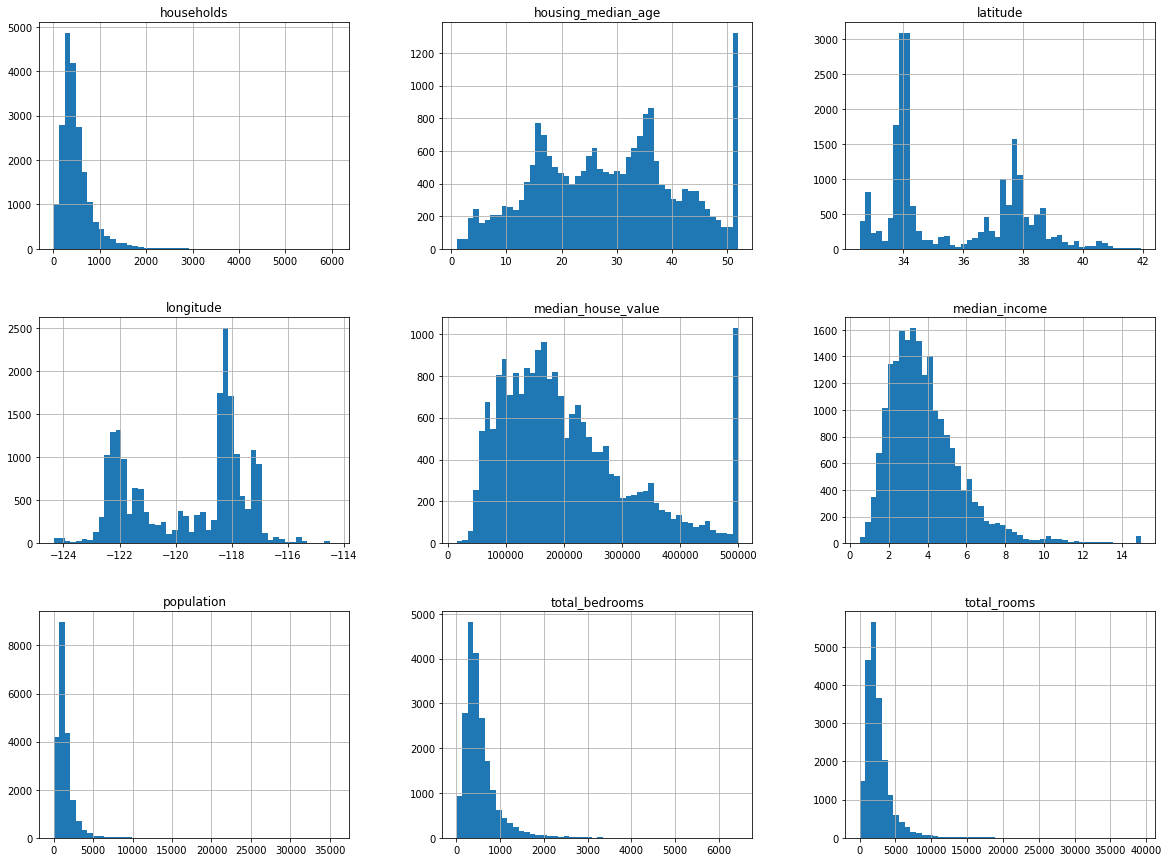

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

#### 1st inspection of data
Income is in units of 10.000 USD; Housing median and values are capped => Model might view is a pattern of the data. If a exact values is required, get real lables or remove caped instances; Attributes have differenct scale; Some histograms are tail-heavy;

#### Create test set
Don't look at the test set to avoide data snooping (Bias towards model that you might think works best for the test set. Human brain is wired to overfitt and find patterns).

In [8]:
def split_train_test(data, test_ratio):
    
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[test_set_size:]
    train_indices = shuffled_indices[:test_set_size]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
# Works fine, however if we run it again different sets emerge and the model
# might see the whole data set. => store afet 1st run or use seed.
# Both break if the data set changes
train_set, test_set = split_train_test(data=housing, test_ratio=0.2)

In [10]:
# Implement solutions based on hashes to make data spliting conistent over versions of
# data set. Works on UI
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
# As housing does not have an UI we generate one.
# Use stable attributes to generate a UI. Note: index might change
housing_with_id = housing.reset_index()   # adds an `index` column
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [12]:
# Or use skitlearn functionality
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

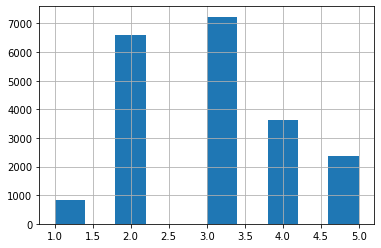

In [13]:
# It is important to have a sufficient number of instances per stratum.  
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

# Plot
housing["income_cat"].hist()
plt.show()

In [14]:
# Stratified sampling based on income catergory
# method of sampling from a population which can be partitioned into subpopulations.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [16]:
# The randomly picked data set is skewed while the stratified one is not (or less).
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [17]:
# remove income_cat to go back to original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

#### Expoloring the data 

In [18]:
# make a copy to play with
housing_cp = strat_train_set.copy()

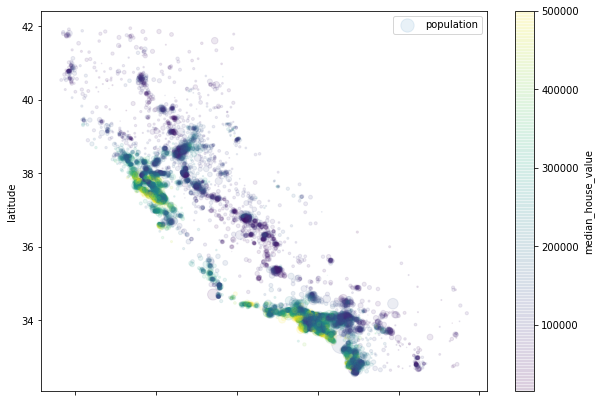

In [19]:
# plot to visualize location
housing_cp.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.1,
    s=housing_cp['population'] / 100,
    label='population',
    figsize=(10,7),
    c='median_house_value',
    cmap=plt.get_cmap('viridis'),
    colorbar=True
)
plt.show()

We see  high prices in clusters and close to the ocean. It would be possible to add features desctibing the distance to these clusters.

##### Correlations

In [20]:
# correlation matrix
# It measures linear correlation 
# It may completely miss no liner correlations
corr_matrix = housing_cp.corr()

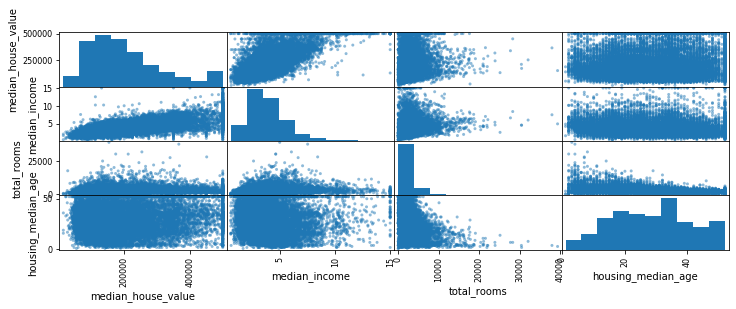

In [21]:
# Plot some correlations
attributes_scatter_matrix = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
pd.plotting.scatter_matrix(housing_cp[attributes_scatter_matrix], figsize=(12,4))
plt.show()

##### Combine attributes

In [22]:
# Some data my not be usefull on its own. I.e. the number of rooms per district is not as interesting as the number of rooms per household.
housing['rooms_per_houshold'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_rooms'] / housing['total_bedrooms'] 
housing['population_per_houshol'] = housing['population'] / housing['households']  

#### Data cleaning 

In [23]:
# go back to original training set
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [24]:
# dealing with missing values
# option 1. get rid of record
# option 2. get rid of attribute
# option 3. set some value

# Example
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

# Vocabulary

#### Pipeline
Sequence of data processing components. Components usually work asynchronously, they take in data from a store, porcess is and store it in another store. Each component is self contained. The interface between the components is the data store.  

#### Stratified data
Ensure sampling data represent population. I.e. 51.3% female to 48.7% male. If not the model might be skewed.